In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [2]:
# Define base distribution
import seaborn as sns
%matplotlib inline

# checking/testing the multivariate normal triL (triL means lower triangular -> the covariance matrix is symmetric)
normal = tfd.MultivariateNormalTriL(loc=[0., 0.])

/Users/thomas.greiner/miniforge3/envs/tensorflow-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


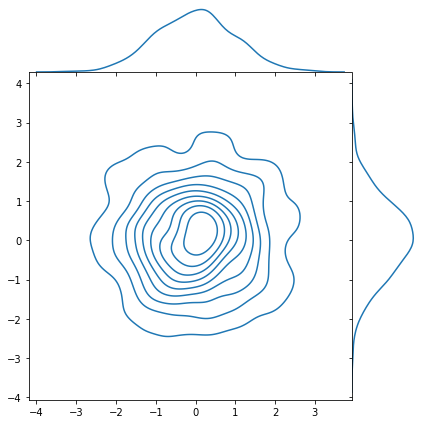

In [3]:
# Sample from base distribution

n = 1000
z = normal.sample(n)

axis1 = z[:, 0]
axis2 = z[:, 1]
sns.jointplot(axis1, axis2, kind='kde', space=0);

### Scale and shift bijector

In [64]:
# Define scale and shift
scale = 4.5
shift = 7

In [45]:
# Define chain bijector

scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

In [46]:
# We can also use call methods

scale_trans = tfb.Scale(scale)
shift_trans = tfb.Shift(shift)
scale_and_shift = shift_trans(scale_trans)

In [47]:
# Apply the forward transformation

x = scale_and_shift.forward(z)

In [48]:
# Check the forward transformation

tf.norm(x - (scale*z + shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Plots

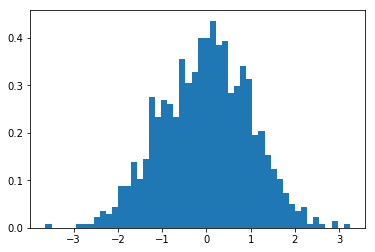

In [49]:
# Plot z density on axis1
plt.hist(z[:,0].numpy(), bins=50, density=True)
plt.show()

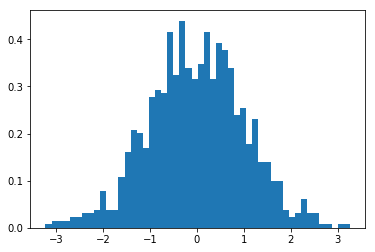

In [50]:
# Plot z density on axis2
plt.hist(z[:,1].numpy(), bins=50, density=True)
plt.show()

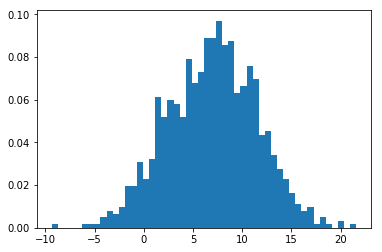

In [51]:
# Plot x density on axis 1
plt.hist(x[:, 0].numpy(), bins=50, density=True)
plt.show()

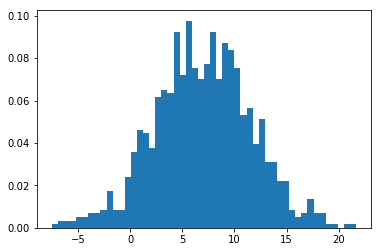

In [52]:
# Plot x density on axis 2
plt.hist(x[:, 1].numpy(), bins=50, density=True)
plt.show()

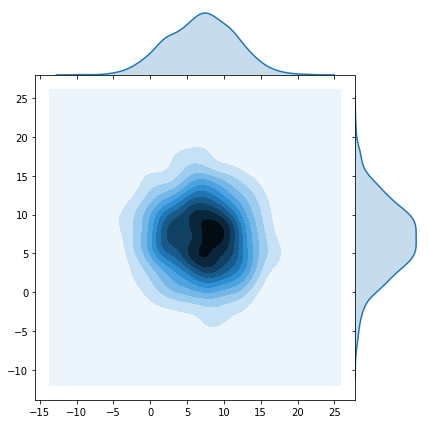

In [53]:
# Plot 2D density for x

axis1 = x[:, 0]
axis2 = x[:, 1]
sns.jointplot(axis1, axis2, kind='kde', space=0);

### Inverse transformation

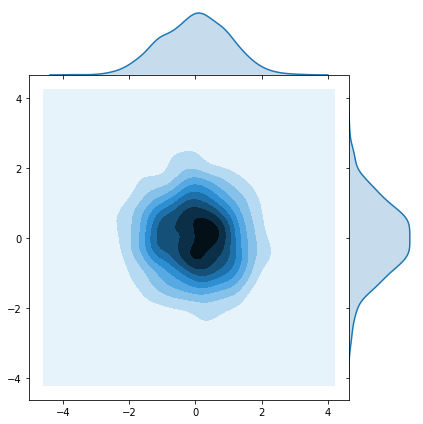

In [63]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(x)
inv_x.shape

axis1 = inv_x[:, 0]
axis2 = inv_x[:, 1]
sns.jointplot(axis1, axis2, kind='kde', space=0);

In [55]:
# Check inverse transformation

tf.norm(inv_x - z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Log probability

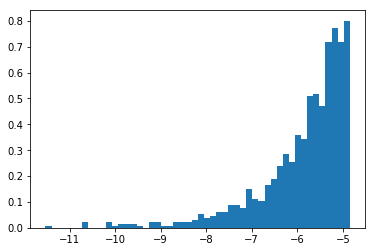

In [60]:
# Compute log prob for x

log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=1)
log_prob_x.shape
plt.hist(log_prob_x.numpy(), bins=50, density=True)
plt.show()

In [62]:
# We can also use the inverse transformation

log_prob_x = (normal.log_prob(scale_and_shift.inverse(x)) 
                            + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=1))
log_prob_x

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([ -6.828985 ,  -6.03586  ,  -4.912062 ,  -6.7690477,  -5.3396945,
        -5.1483183,  -9.236184 ,  -7.0420265,  -6.370721 ,  -5.090711 ,
        -5.308421 ,  -5.0445695,  -5.6062875,  -5.0568094,  -7.2967343,
        -6.486706 ,  -6.921429 ,  -6.401545 ,  -7.741075 ,  -4.91895  ,
        -5.592677 ,  -4.9787183,  -6.0330334,  -7.0169816,  -5.102832 ,
        -4.907197 ,  -4.9516935,  -5.232914 ,  -5.1616926,  -5.6927314,
        -5.8918605,  -6.444077 ,  -5.5516195,  -7.113144 ,  -6.734983 ,
        -5.508973 ,  -4.946674 ,  -5.95842  ,  -5.109784 ,  -4.888786 ,
        -5.378849 ,  -6.096449 ,  -5.164559 ,  -5.105432 ,  -5.0873365,
        -5.145481 ,  -6.2117796,  -5.020543 ,  -6.1593266,  -5.354772 ,
        -5.8396482,  -5.2131495,  -5.7247214,  -5.7578883,  -6.14788  ,
        -5.212696 ,  -5.21329  ,  -6.0244126,  -6.485408 ,  -5.240121 ,
        -5.716127 , -10.612196 ,  -5.256703 ,  -6.041237 ,  -5.366635 ,
        -6.0425

### Broadcasting

In [30]:
x = tf.random.normal(shape=(100, 1))

In [31]:
# Softfloor bijector

softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)

(100, 1)


In [32]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.2, 1.])
y = softfloor.forward(x)
print(y.shape)

(100, 2)


In [33]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01, 0.1, 1.])


In [34]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

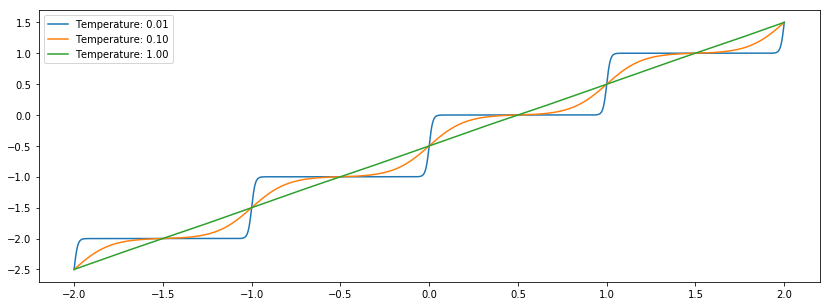

In [37]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]
_plot(3, softfloor, ['temperature'], x)

In [38]:
# Gumbel bijector using broadcasting

exps = tfb.GumbelCDF(loc=[0.5, 1, 1.5, 2, 3], scale=[1, 2, 2, 3, 4])

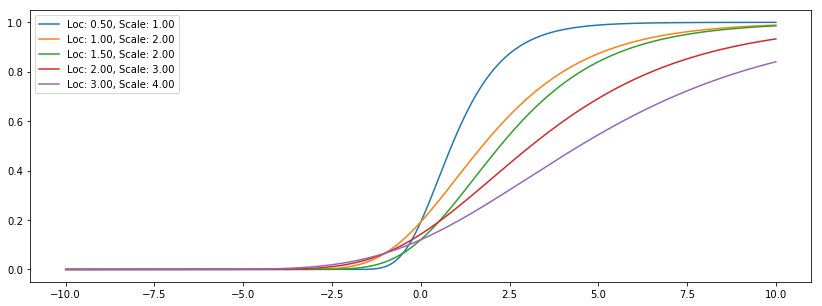

In [39]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5, exps, ['loc', 'scale'], x)

***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [3]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [4]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [5]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [6]:
# Exponential bijector

exp = tfb.Exp()

In [7]:
# Log normal transformed distribution using exp and normal bijectors

log_normal_td = exp(normal)

In [11]:
# Display event and batch shape

print('batch shape: ', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)

batch shape:  ()
event shape:  ()


In [13]:
# Base distribution

z = normal.sample(n)

#### Plots

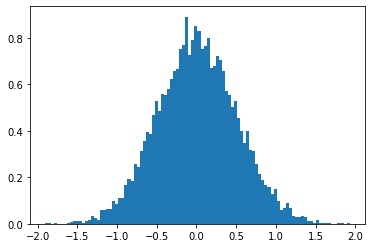

In [14]:
# Plot z density

plt.hist(z.numpy(), bins=100, density=True)
plt.show()

In [15]:
# Transformed distribution

x = log_normal_td.sample(n)

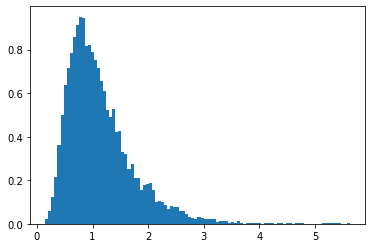

In [16]:
# Plot x density

plt.hist(x.numpy(), bins=100, density=True)
plt.show()

In [17]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc, scale=scale)

In [18]:
# Sample log_normal

l = log_normal.sample(n)

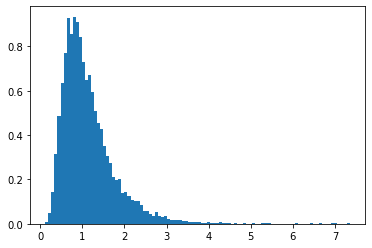

In [19]:
# Plot l density

plt.hist(l.numpy(), bins=100, density=True)
plt.show()

#### Log probability

In [20]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [21]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [22]:
# Check log probs

tf.norm(log_prob - log_prob_td)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Event shape and batch shape

In [72]:
# Set a scaling lower triangular matrix
tril = tf.random.normal((2, 4, 4))
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril)
tril

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[-1.0201799 , -0.07953911,  1.0401366 , -0.43099016],
        [ 0.3725588 , -0.33210775,  1.4570543 , -0.6395174 ],
        [ 0.06431418, -1.3050932 ,  0.6606474 ,  0.04094495],
        [ 0.01382225,  2.1385636 , -0.06819613,  0.158645  ]],

       [[-1.5911748 , -0.36298305, -0.5179792 , -1.1319302 ],
        [-0.04061551, -1.5483248 ,  0.5013587 ,  0.4863177 ],
        [-1.8780366 ,  0.56903595,  1.0025556 , -1.0012227 ],
        [ 0.2464845 ,  1.3575732 , -0.55501884,  1.9517902 ]]],
      dtype=float32)>

In [42]:
# View of scale_low_tri
scale_low_tri.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.25003782,  0.        ,  0.        ,  0.        ],
        [-0.18311138,  1.0188243 ,  0.        ,  0.        ],
        [-1.5495886 , -1.0184337 ,  0.23157187,  0.        ],
        [ 2.5429146 ,  0.5024163 ,  1.4432231 , -0.16381688]],

       [[ 1.9282908 ,  0.        ,  0.        ,  0.        ],
        [ 0.6137969 , -1.5935254 ,  0.        ,  0.        ],
        [-0.74063146,  1.0561738 , -1.7264277 ,  0.        ],
        [-0.9772268 , -0.80466306,  0.13841738, -1.0859717 ]]],
      dtype=float32)>

In [40]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)
scale_lin_op

<tfp.bijectors.ScaleMatvecLinearOperator 'scale_matvec_linear_operator' batch_shape=[2] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=float32 dtype_y=float32>

In [84]:
# Define scale linear operator transformed distribution with a batch and event shape
shape = tf.zeros([2, 4])

normal = tfd.MultivariateNormalDiag(loc=shape, scale_diag=shape)
#normal = tfd.Normal(loc=shape, scale=shape + 1)

mvn = tfd.TransformedDistribution(distribution=normal, bijector=scale_lin_op)
#print(mvn)
print(normal.sample(1))
print(normal)


tf.Tensor(
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]]], shape=(1, 2, 4), dtype=float32)
tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[2], event_shape=[4], dtype=float32)


In [85]:
# Display event and batch shape

print('batch shape: ', mvn.batch_shape)
print('event shape: ', mvn.event_shape)

batch shape:  (2,)
event shape:  (4,)


In [86]:
# Sample

y1 = mvn.sample(sample_shape=(n, ))
print(y1.shape)

(10000, 2, 4)


In [36]:
# Define a MultivariateNormalLinearOperator distribution

mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale=scale_low_tri)
print(mvn2)

tfp.distributions.MultivariateNormalLinearOperator("MultivariateNormalLinearOperator", batch_shape=[2], event_shape=[4], dtype=float32)


In [37]:
# Display event and batch shape

print('batch shape: ', mvn2.batch_shape)
print('event shape: ', mvn2.event_shape)

batch shape:  (2,)
event shape:  (4,)


In [38]:
# Sample

y2 = mvn2.sample(sample_shape=(n, ))
print(y2.shape)

(10000, 2, 4)


In [46]:
# Check
xn = normal.sample((n, 2, 4))
tf.norm(mvn.log_prob(xn) - mvn2.log_prob(xn)) / tf.norm(mvn.log_prob(xn))

<tf.Tensor: shape=(), dtype=float32, numpy=0.7252549>

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [27]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))

    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))



In [ ]:
        
class MySigmoid(tfb.Bijector):
    
    def __init__(self, validate_args=False, name='sigmoid'):
        super(MySigmoid, self).__init__(validate_args=validate_args, 
                                        forward_min_event_ndims=0, 
                                        name=name,
                                        is_constant_jacobian=True)
        
    def _forward(self, x):
        return tf.math.sigmoid(x)

    def _inverse(self, y):
        return tf.math.log(y) - tf.math.log(1 - y)

    def _inverse_log_det_jacobian(self, y):
        return -tf.math.log(y) - tf.math.log(1 - y)

    def _forward_log_det_jacobian(self, x):
        return -self._inverse_log_det_jacobian(self._forward(x))
        
        

In [28]:
# Cubic bijector

cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)

In [29]:
# Apply forward transformation

x = tf.constant([[1, 2],[3, 4]])
y = cubic.forward(x)
print(y)

tf.Tensor(
[[   0.        -46.655994]
 [   8.       -438.97598 ]], shape=(2, 2), dtype=float32)


In [30]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

#### Function plots

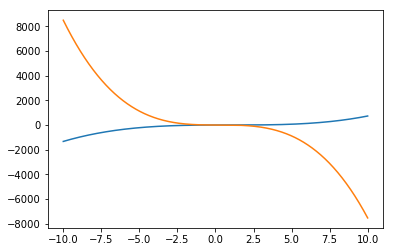

In [31]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x))

In [32]:
# Display shape

print(cubic.forward(x).shape)

(500, 2)


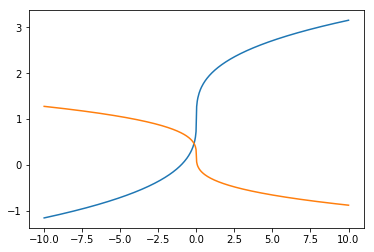

In [33]:
# Plot the inverse

plt.plot(x, cubic.inverse(x))

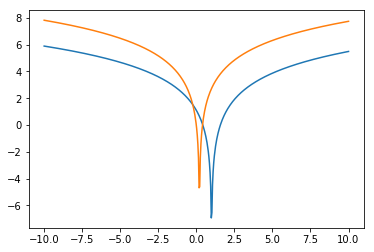

In [34]:
# Plot the forward log Jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))

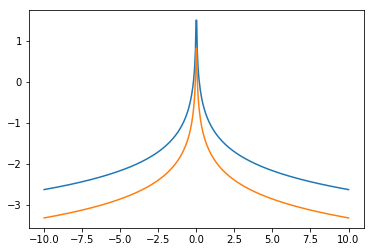

In [35]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0))

#### TransformedDistribution and plots

In [36]:
# Create a transformed distribution with Cubic

normal = tfd.Normal(loc=0., scale=1.)
cubed_normal = tfd.TransformedDistribution(normal, cubic, event_shape=[2])

In [37]:
# Sample cubed_normal
n = 1000
g = cubed_normal.sample(n)
g.shape


TensorShape([1000, 2])

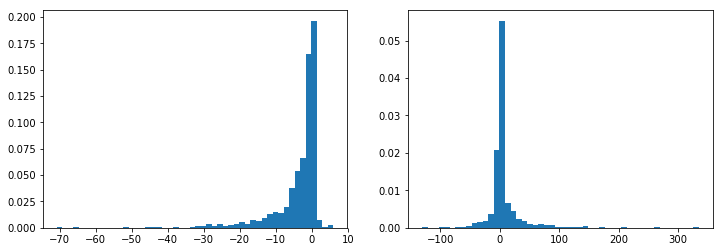

In [38]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

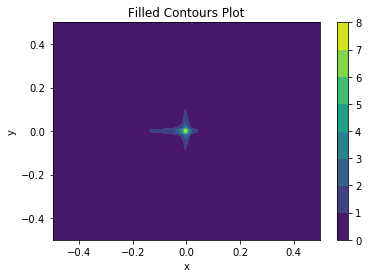

In [42]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [43]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal, event_shape=[2])

In [44]:
# Samble inv_cubed_normal

n = 1000
g = inv_cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

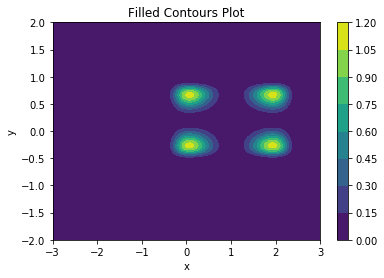

In [45]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

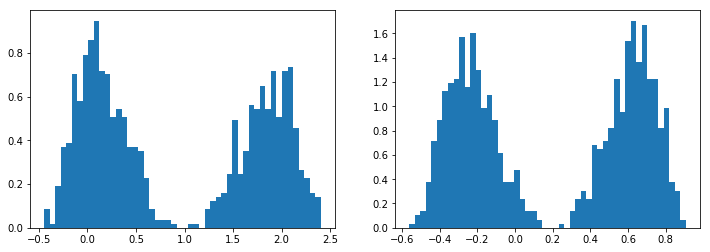

In [46]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

#### Training the bijector

In [48]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3, scale=0.4),
        tfd.Normal(loc=-0.8, scale=0.4)
    ])

In [49]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


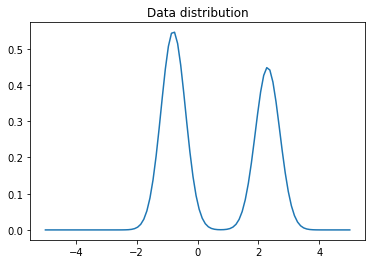

In [51]:
# Plot the data distribution

x = np.linspace(-5.0, 5.0, 100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()

In [52]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic

In [54]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

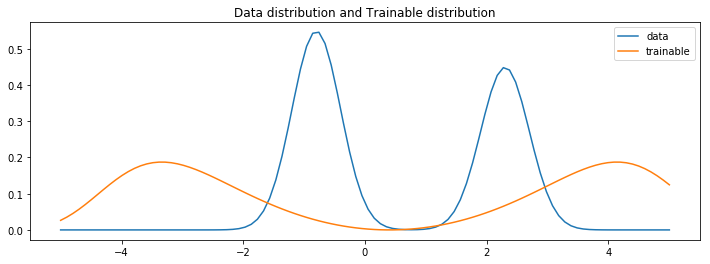

In [55]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5.0, 100)

plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.legend()
plt.title('Data distribution and Trainable distribution')
plt.show()

In [57]:
# Train the bijector

num_epochs = 20
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...


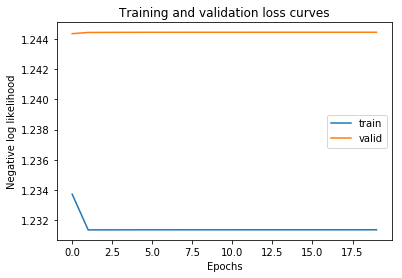

In [58]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

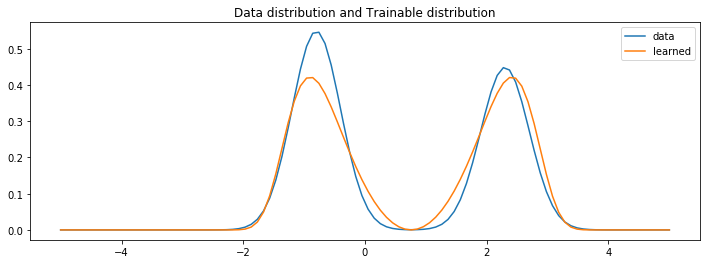

In [59]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5.0, 100)

plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='learned')
plt.legend()
plt.title('Data distribution and Trainable distribution')
plt.show()

In [61]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5633655>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.42609042>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [2]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

(-2, 2)

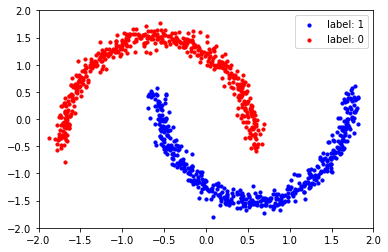

In [3]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

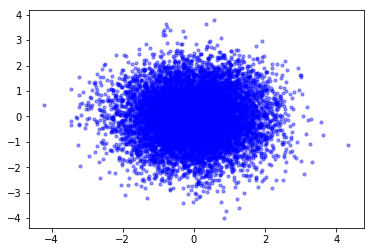

In [15]:
# Define base distribution -> the simple distribution that we want to transform from

base_distribution = tfd.Normal(loc=0, scale=1)

sample_base_distr = base_distribution.sample([10000, 2])
plt.scatter(sample_base_distr[:, 0], sample_base_distr[:, 1], s=10, color='blue', alpha=0.4)


In [17]:
# Define the trainable distribution -> the distribtuion we want to train going from simple to more complex

def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(
                params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution,
                                                     make_masked_autoregressive_flow(),
                                                     event_shape=[2])




In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [19]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

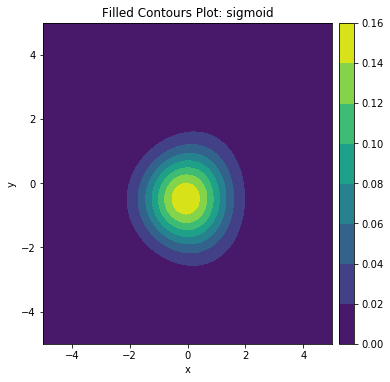

In [25]:
# Plot contour

activation = 'sigmoid'
maf = tfd.TransformedDistribution(base_distribution,
                                  make_masked_autoregressive_flow(activation=activation),
                                  event_shape=[2])
plot_contour_prob([maf], scale_fig=6, title=[activation])


In [26]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [27]:
# Make samples

x = base_distribution.sample((1000, 2))
names = [base_distribution.name, trainable_distribution.name]
samples = [x, trainable_distribution.bijector.forward(x)]


In [28]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

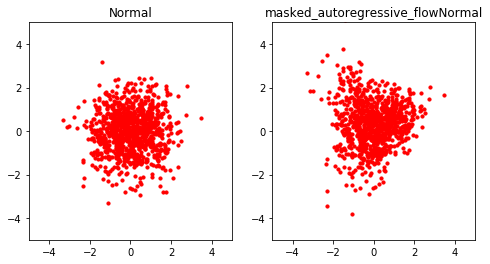

In [29]:
# Plot

_plot(samples)


#### Training a MaskedAutoregressiveFlow bijector

In [30]:
from tensorflow.keras.callbacks import LambdaCallback

In [31]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [32]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 3.1361, val_loss: 3.1295

 Epoch 51/600 
	 loss: 2.7526, val_loss: 2.7469

 Epoch 101/600 
	 loss: 2.6684, val_loss: 2.6689

 Epoch 151/600 
	 loss: 2.6512, val_loss: 2.6539

 Epoch 201/600 
	 loss: 2.6311, val_loss: 2.6368

 Epoch 251/600 
	 loss: 2.6037, val_loss: 2.6096

 Epoch 301/600 
	 loss: 2.5634, val_loss: 2.5667

 Epoch 351/600 
	 loss: 2.4771, val_loss: 2.4817

 Epoch 401/600 
	 loss: 2.3487, val_loss: 2.3651

 Epoch 451/600 
	 loss: 2.2658, val_loss: 2.3015

 Epoch 501/600 
	 loss: 2.2077, val_loss: 2.2573

 Epoch 551/600 
	 loss: 2.1567, val_loss: 2.2193


In [33]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

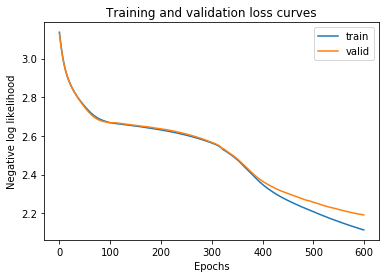

In [34]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [35]:
# Make samples

x = base_distribution.sample((1000, 2))
names = [base_distribution.name, trainable_distribution.name]
samples = [x, trainable_distribution.bijector.forward(x)]


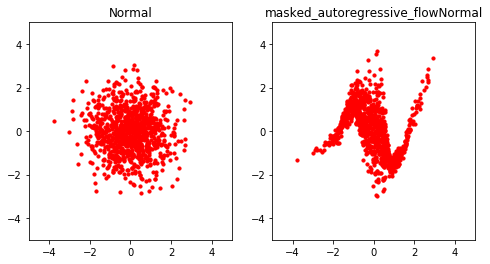

In [36]:
# Plot

_plot(samples)


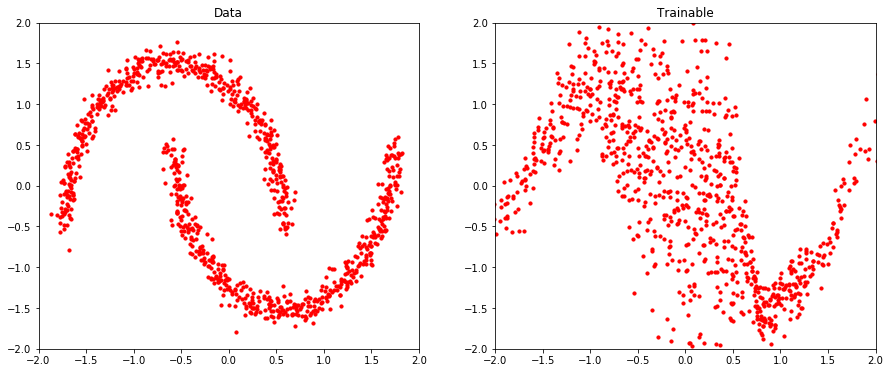

In [37]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

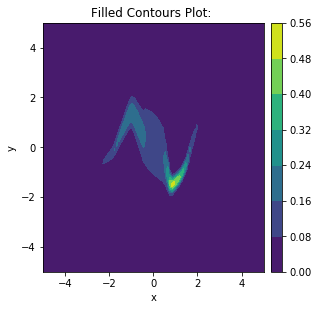

In [41]:
# Plot contour

plot_contour_prob([trainable_distribution], scale_fig=5)

#### Training a chain of MaskedAutoregressiveFlow bijectors

In [46]:
# Define a more expressive model

num_bijectors = 6
bijectors = []
for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256, 256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1, 0]))

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
flow_bijector

In [47]:
# Define the trainable distribution

trainable_distribution = tfd.TransformedDistribution(distribution=base_distribution,
                                                     bijector=flow_bijector,
                                                     event_shape=[2])

In [48]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

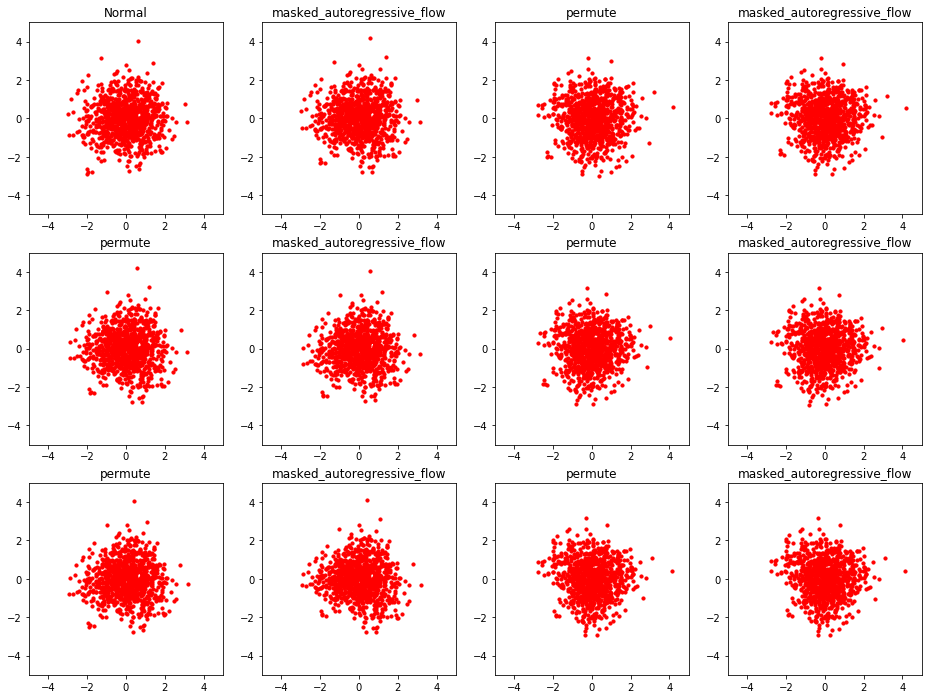

In [49]:
# Plot

_plot(samples, 3)


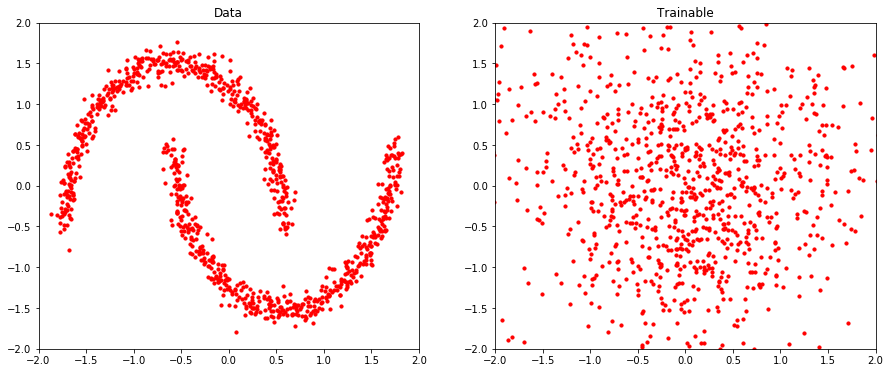

In [50]:
# Plot

visualize_training_data(samples)

In [51]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.7977, val_loss: 2.7120

 Epoch 51/600 
	 loss: 2.3996, val_loss: 2.5538

 Epoch 101/600 
	 loss: 2.0073, val_loss: 2.1509

 Epoch 151/600 
	 loss: 1.8887, val_loss: 1.8991

 Epoch 201/600 
	 loss: 1.8279, val_loss: 1.7430

 Epoch 251/600 
	 loss: 1.4868, val_loss: 1.5396

 Epoch 301/600 
	 loss: 1.3247, val_loss: 1.3879

 Epoch 351/600 
	 loss: 1.2032, val_loss: 1.3074

 Epoch 401/600 
	 loss: 1.1327, val_loss: 1.3271

 Epoch 451/600 
	 loss: 1.0953, val_loss: 1.1914

 Epoch 501/600 
	 loss: 1.0763, val_loss: 1.2373

 Epoch 551/600 
	 loss: 1.1026, val_loss: 1.1746


In [52]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

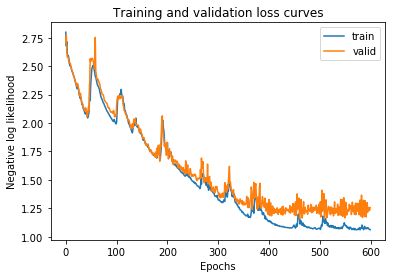

In [53]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

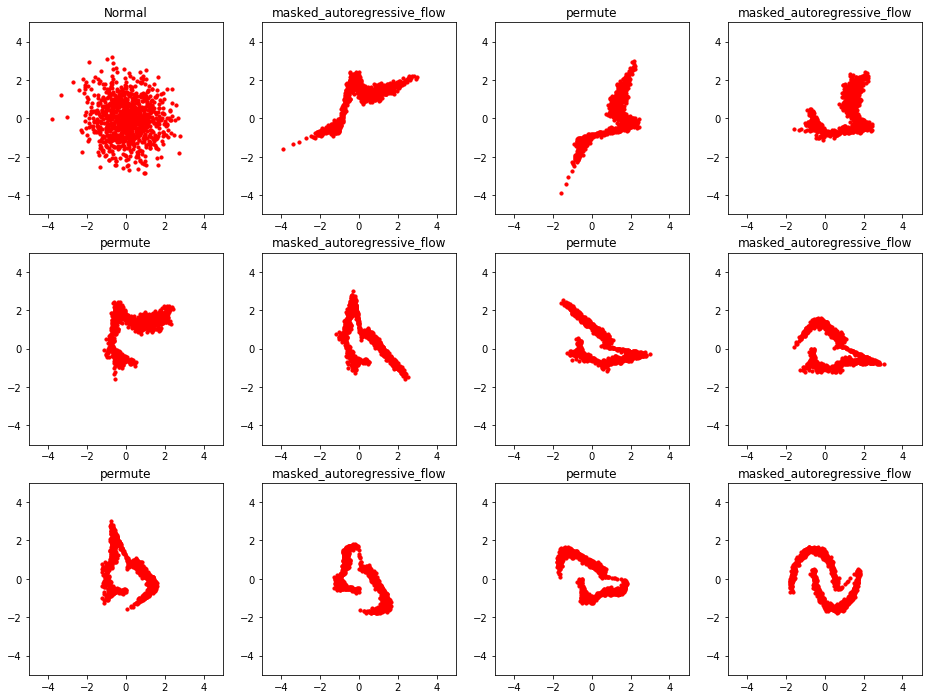

In [54]:
# Make samples and plot

names, samples = make_samples()
_plot(samples, 3)

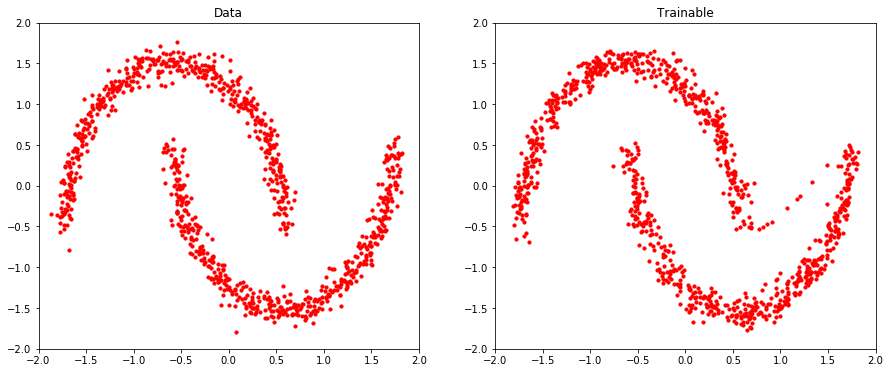

In [55]:
# Plot

visualize_training_data(samples)

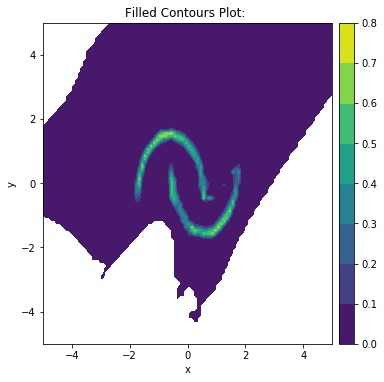

In [56]:
# Plot

plot_contour_prob([trainable_distribution], scale_fig=6)